# Building a multiclass classification model using a custom convolutional neural network in TensorFlow

## An Assignment by Irfan Khan Mohammed

### Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


### The data set contains the following diseases:


*   Actinic keratosis
*   Basal cell carcinoma
*   Dermatofibroma
*   Melanoma
*   Pigmented benign keratosis
*   Nevus
*   Seborrheic keratosis
*   Squamous cell carcinoma
*   Vascular lesion

## Tasks Involved on this Assignment
### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

# 1. Data Reading/Data Understanding


## 1.1 Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Input, Add, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from keras.optimizers import SGD
from glob import glob
from sklearn.preprocessing import LabelEncoder
from collections import Counter

## 1.2 Mounting of Data to Colab from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## 1.3 Defining the path for train and test images
#### Updating the paths of the train and test dataset after mounting on Google Colab Drive from Google Drive

In [3]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/Skin_Cancer/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Skin_Cancer/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### Creating a Dataset and Parameters

Defining parameters like batch size, height and width of images for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

## 1.4 Writing Train Dataset
### Loading Images using keras.preprocessing

Loading these images off disk using the helpful image_dataset_from_directory utility.

#### Using seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
#### Resizing the images to the size img_height*img_width [180 X 180]
#### Will be Using 80% of the images for training, and 20% for validation.

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


## 1.5 Writing Validation Dataset
#### Using seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
#### Resizing the images to the size img_height*img_width [180 X 180]

In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


## 1.6 Listing of All Classes of Skin Cancer and Storing in a List.
#### Finding the class names in the class_names attribute on these datasets.
#### These correspond to the directory names in alphabetical order.

In [8]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# 2. Dataset Visualisation

## 2.1 Creating a code to visualize one instance of all the nine classes present in the dataset.

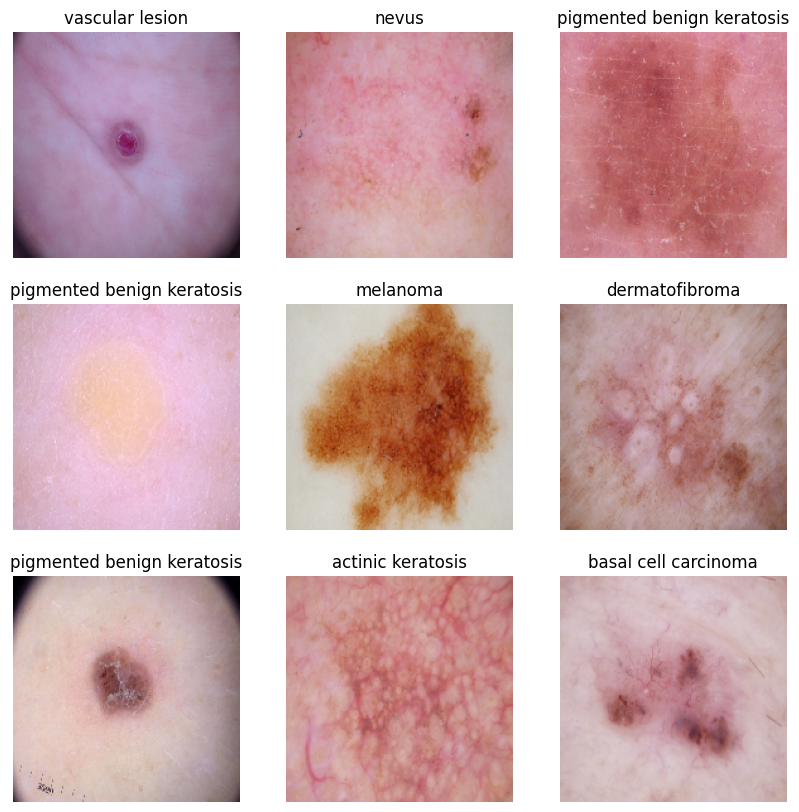

In [9]:
### Using training data to visualize

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

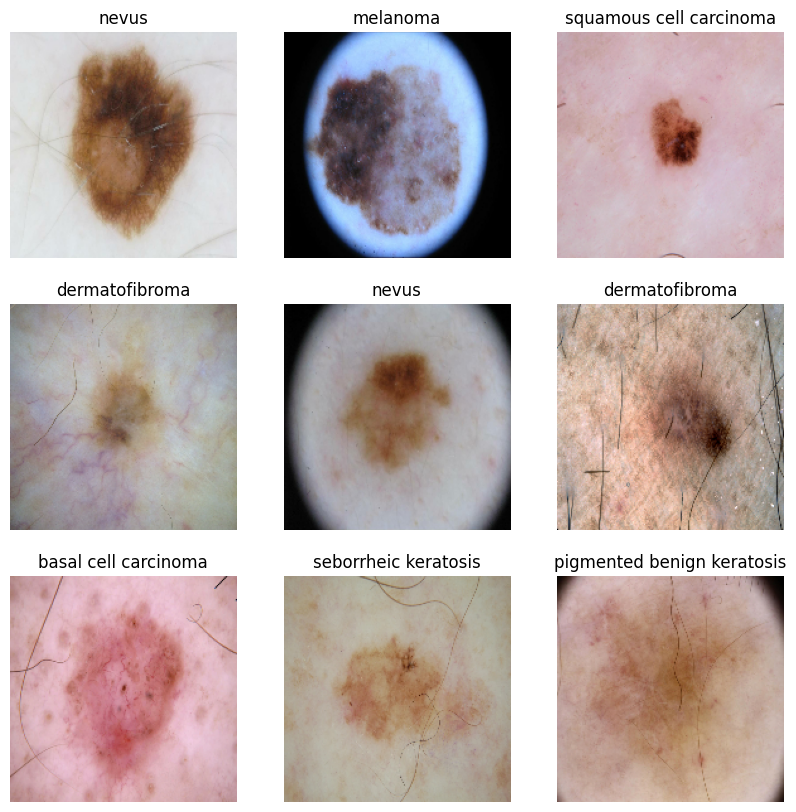

In [10]:
### Using validation data to visualize

plt.figure(figsize = (10,10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

## 2.2 Performing Auto Tune on datasets

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 3. Model Building & Training

## 3.1 Creating the model
### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range.
### This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`.
#### To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1./255.

In [12]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Normalization(axis=-1, mean=None, variance=None, invert=False),
#First Convulation layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
#Second Convulation Layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
#Third Convulation Layer
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
#Dropout layer with 50% Fraction of the input units to drop.
  layers.Dropout(0.5),
#Flatten Layer
  layers.Flatten(),
#Dense Layer
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


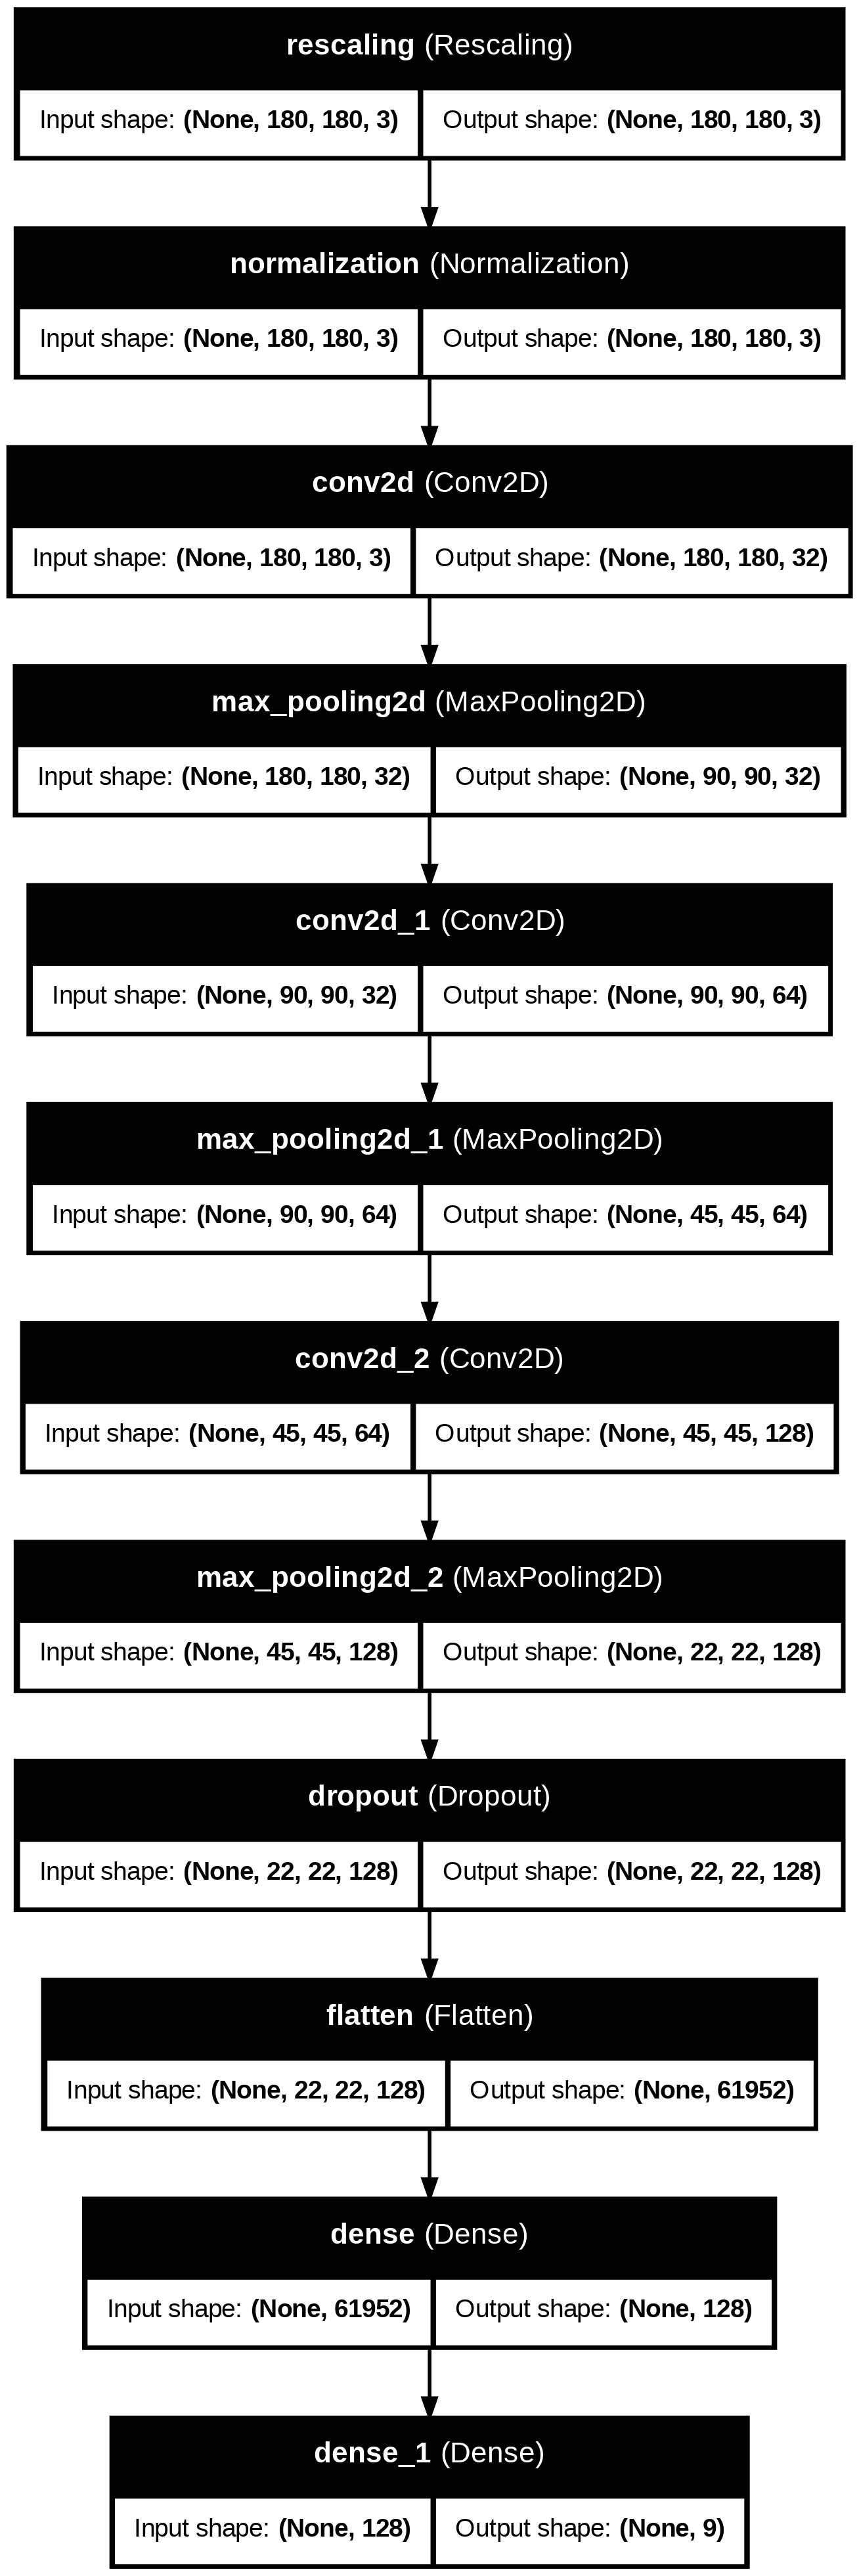

In [13]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## 3.2 Compile the model
#### Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#### SparseCategoricalCrossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 180, 180, 3)         │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,400 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 7 (32.00 B)

## 3.3 Training the model
### Training the Model with 20 epochs

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.2365 - loss: 2.2133 - val_accuracy: 0.0870 - val_loss: 2.2470
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.4269 - loss: 1.6424 - val_accuracy: 0.3043 - val_loss: 2.6281
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.4274 - loss: 1.6540 - val_accuracy: 0.2174 - val_loss: 2.0098
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.5079 - loss: 1.4090 - val_accuracy: 0.1739 - val_loss: 2.5288
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.5182 - loss: 1.3539 - val_accuracy: 0.2174 - val_loss: 2.6273
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.5658 - loss: 1.2367 - val_accuracy: 0.1739 - val_loss: 3.1656
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.5528 - loss: 1.2498 - val_accuracy: 0.1739 - val_loss: 2.6216
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.6138 - loss: 1.0829 - val_accuracy: 0.1739 - v

## 3.4 Visualizing Training Results
### Training and Validation Accuracy and Loss.

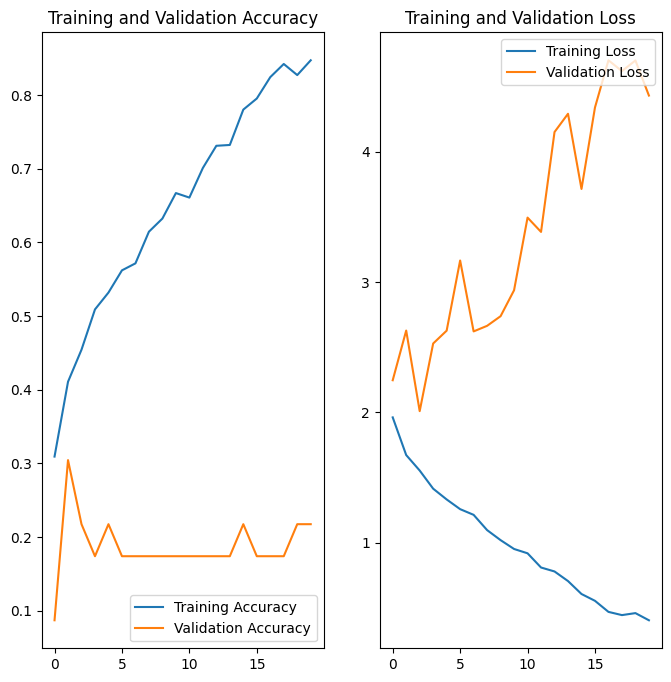

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

## 3.5 Findings from Model Building & Training

 1. Found a drastic difference between Traning Accuracy 84.4% and Validation Accuracy higest was 30.4%, which indicates that the model has overfitted.
 2. Noticed that the validation accuracy the model has achieved is below 35%.
 3. Overall we need to apply techniques like Data Augmentation and Dropout to handle the overfitting issue of the model

# 4. Chosing Augmentation Strategy
## 4.1 Chosing an appropriate data augmentation strategy to resolve overfitting issue.

In [18]:
# Using RandomFlip to Horizontal Strategy of Augmentation

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## 4.2 Visualizing if Augmentation Strategy
### Visualizing augmentation strategy works for one instance of training image.

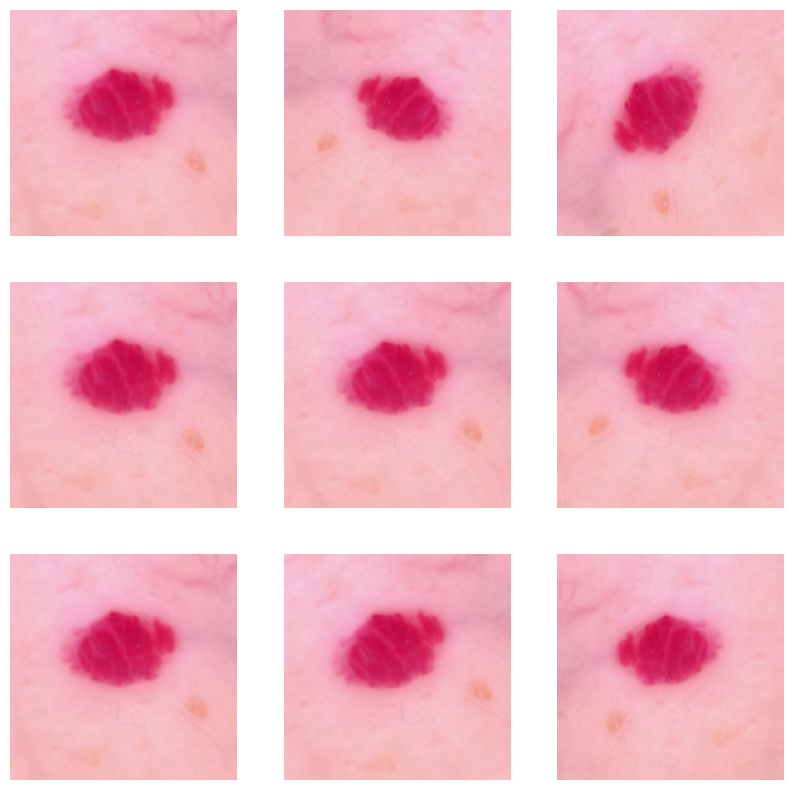

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## 4.3 Creating the model again with dropout of 0.05.

In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Normalization(axis=-1, mean=None, variance=None, invert=False),
#First Convulation layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
#Second Convulation Layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
#Third Convulation Layer
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
#Fourth Convulation Layer
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
#Dropout layer with 50% Fraction of the input units to drop.
  layers.Dropout(0.5),
#Flatten Layer
  layers.Flatten(),
#Dense Layer
  layers.Dense(256, activation='relu'),
#Dropout layer with 25% Fraction of the input units to drop.
  layers.Dropout(0.25),
  layers.Dense(num_classes)
])

## 4.4 Compiling the model with Dropout

In [21]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 4.5 Training the model with Dropout

In [ ]:
## Your code goes here, note: train your model for 20 epochs
## your training code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.1906 - loss: 2.2461 - val_accuracy: 0.1304 - val_loss: 2.4336
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.2685 - loss: 1.9214 - val_accuracy: 0.2609 - val_loss: 2.3890
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.3771 - loss: 1.7163 - val_accuracy: 0.0870 - val_loss: 2.9728
Epoch 4/20
36/56 ━━━━━━━━━━━━━━━━━━━━ 1:12 4s/step - accuracy: 0.3724 - loss: 1.7342

## 4.6 Visualizing the results with Dropout

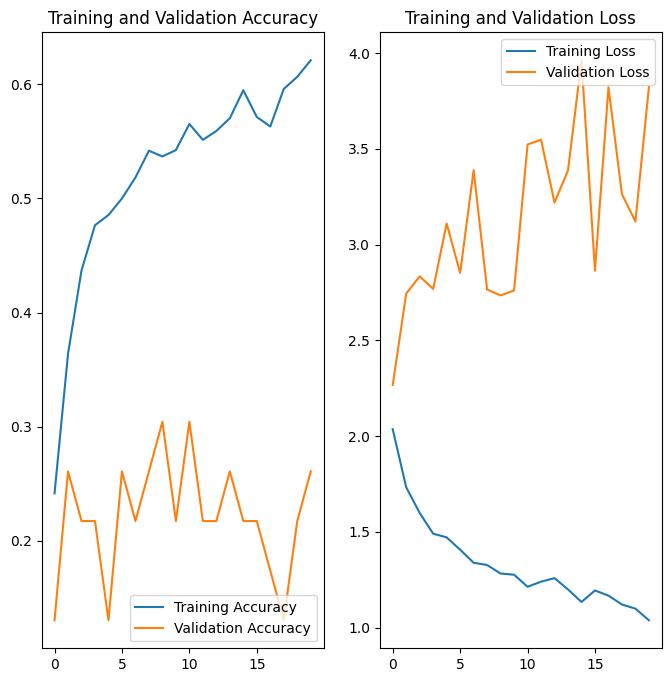

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

1. Found a drastic difference between Traning Accuracy (highest = 61.3%) and Validation Accuracy (highest = 30.4%), which indicates that the model has overfitted.
2. Noticed that the validation accuracy the model has achieved is below 35%.
3. There is no improvement compared to previous we ran.

# 5. Class Distribution

### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Class=8, n=139 (6.21%)
Class=1, n=376 (16.79%)
Class=3, n=438 (19.56%)
Class=7, n=181 (8.08%)
Class=4, n=357 (15.94%)
Class=2, n=95 (4.24%)
Class=0, n=114 (5.09%)
Class=5, n=462 (20.63%)
Class=6, n=77 (3.44%)


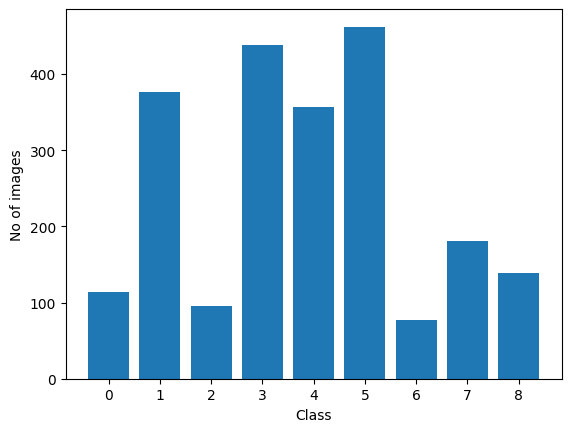

In [ ]:
X, y = data1['Path'], data1['Label']
y = LabelEncoder().fit_transform(y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.2f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.xticks([i for i in range(9)])
plt.xlabel("Class")
plt.ylabel("No of images")
plt.show()

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
data1 = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
data1


,Path,Label
0,/content/drive/MyDrive/Skin_Cancer/Train/vascu...,vascular lesion
1,/content/drive/MyDrive/Skin_Cancer/Train/vascu...,vascular lesion
2,/content/drive/MyDrive/Skin_Cancer/Train/vascu...,vascular lesion
3,/content/drive/MyDrive/Skin_Cancer/Train/vascu...,vascular lesion
4,/content/drive/MyDrive/Skin_Cancer/Train/vascu...,vascular lesion
...,...,...
2234,/content/drive/MyDrive/Skin_Cancer/Train/sebor...,seborrheic keratosis
2235,/content/drive/MyDrive/Skin_Cancer/Train/sebor...,seborrheic keratosis
2236,/content/drive/MyDrive/Skin_Cancer/Train/sebor...,seborrheic keratosis
2237,/content/drive/MyDrive/Skin_Cancer/Train/sebor...,seborrheic keratosis


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
## Class 6 has least value with 77 images contributing to 3.44%
#### - Which classes dominate the data in terms proportionate number of samples?
## Class 5 has Highest value with 462 images contributing to 20.63%

# 6. Handling class imbalances

### Rectifying the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

## 6.1 Installing Augmentor

In [ ]:
!pip install Augmentor

## 6.2 Instantiating Pipeline for Augmentor

### Using `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/drive/MyDrive/Skin_Cancer/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/drive/MyDrive/Skin_Cancer/Train/"+ "/" + i, output_directory = '/content/skin_cancer/train/' + i +'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(2500) ## We are adding 2500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/skin_cancer/train/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E55322A2C20>: 100%|██████████| 5000/5000 [03:04<00:00, 27.11 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/skin_cancer/train/basal cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E549D4D7C70>: 100%|██████████| 5000/5000 [03:03<00:00, 27.29 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/skin_cancer/train/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E55299333D0>: 100%|██████████| 5000/5000 [03:04<00:00, 27.09 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/skin_cancer/train/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7E55C1771240>: 100%|██████████| 5000/5000 [13:53<00:00,  6.00 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/skin_cancer/train/nevus/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7E549D490760>: 100%|██████████| 5000/5000 [12:42<00:00,  6.55 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/skin_cancer/train/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E549D3A3DC0>: 100%|██████████| 5000/5000 [02:48<00:00, 29.73 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/skin_cancer/train/seborrheic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E5529FDE470>: 100%|██████████| 5000/5000 [06:10<00:00, 13.51 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/skin_cancer/train/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E552992E320>: 100%|██████████| 5000/5000 [02:42<00:00, 30.82 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/skin_cancer/train/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E5527CFCA30>: 100%|██████████| 5000/5000 [02:47<00:00, 29.90 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
output_dir = pathlib.Path("/content/skin_cancer/train/")

In [ ]:
image_count_train = len(list(output_dir.glob("*/output/*.jpg")))
print(image_count_train)

45000


## 6.3 Adding new images to Distribution

### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
path_list [:20]

['/content/skin_cancer/train/melanoma/output/melanoma_original_ISIC_0000441.jpg_2b065301-b468-420c-bb39-887f6817d542.jpg',
 '/content/skin_cancer/train/melanoma/output/melanoma_original_ISIC_0010143.jpg_404b59f9-f2a8-4dfa-8cd9-ce761ba79638.jpg',
 '/content/skin_cancer/train/melanoma/output/melanoma_original_ISIC_0010208.jpg_d713f21f-a934-4444-b95f-0913ceb8e3db.jpg',
 '/content/skin_cancer/train/melanoma/output/melanoma_original_ISIC_0010478.jpg_0784d7a9-d7ba-41aa-a67c-c5949114ea68.jpg',
 '/content/skin_cancer/train/melanoma/output/melanoma_original_ISIC_0000459.jpg_941ea9c8-a656-488e-bbfb-7b22f4b9fad7.jpg',
 '/content/skin_cancer/train/melanoma/output/melanoma_original_ISIC_0000295.jpg_83ce1580-6530-4fdc-b2cd-06b55a4e1c6d.jpg',
 '/content/skin_cancer/train/melanoma/output/melanoma_original_ISIC_0000466.jpg_e9781f16-3348-4f99-9f75-f4b718265ea5.jpg',
 '/content/skin_cancer/train/melanoma/output/melanoma_original_ISIC_0000304.jpg_597e2aa4-103f-47e7-877f-17170d23bee0.jpg',
 '/content/skin_

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
lesion_list_new [:20]

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma']

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
data2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = data1._append(data2)

In [ ]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,5462
melanoma,5438
basal cell carcinoma,5376
nevus,5357
squamous cell carcinoma,5181
vascular lesion,5139
actinic keratosis,5114
dermatofibroma,5095
seborrheic keratosis,5077


So, now we have added 5000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# 7. Model Building & training on the rectified class imbalance data

### Training the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

## 7.1 Creating a training dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


## 7.2 Creating a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


## 7.3 Creating the model

In [ ]:
## your code goes here
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Normalization(axis=-1, mean=None, variance=None, invert=False),
#First Convulation layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
#Second Convulation Layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
#Third Convulation Layer
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
#Fourth Convulation Layer
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
#Dropout layer with 50% Fraction of the input units to drop.
  layers.Dropout(0.5),
#Flatten Layer
  layers.Flatten(),
#Dense Layer
  layers.Dense(256, activation='relu'),
#Dropout layer with 25% Fraction of the input units to drop.
  layers.Dropout(0.25),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 7.4 Compiling the Model

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 7.5 Training the Model with 30 epochs

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 415ms/step - accuracy: 0.2534 - loss: 2.0497 - val_accuracy: 0.3557 - val_loss: 1.7903
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.3831 - loss: 1.7169 - val_accuracy: 0.3758 - val_loss: 1.7812
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 343ms/step - accuracy: 0.4074 - loss: 1.6450 - val_accuracy: 0.4676 - val_loss: 1.5442
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 323ms/step - accuracy: 0.4747 - loss: 1.4987 - val_accuracy: 0.5034 - val_loss: 1.4323
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 365ms/step - accuracy: 0.4895 - loss: 1.4142 - val_accuracy: 0.5235 - val_loss: 1.3742
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 329ms/step - accuracy: 0.5366 - loss: 1.3567 - val_accuracy: 0.5123 - val_loss: 1.4067
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step - accuracy: 0.5220 - loss: 1.3293 - val_accuracy: 0.5011 - val_loss: 1.4432
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 339ms/step - accuracy: 0.5097 - loss: 1.3485 - val_accu

## 7.6 Visualizing the model results

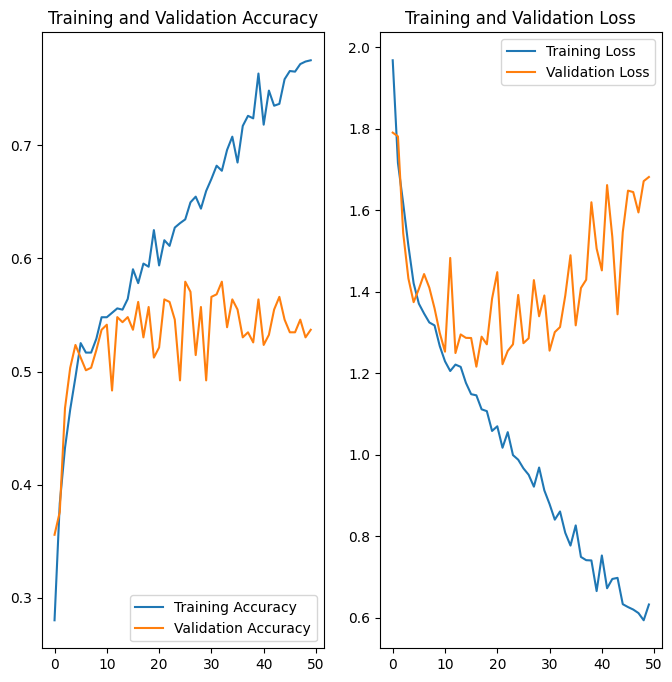

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 7.7 Analyze the Results
